# Direct Policy Search for Lake Pollution Control

This notebook implements a stochastic optimization of P discharges from a wastewater treatment plant to maximize discounted economic utility:

$\text{Maximize } \mathbb{E}\Bigg[\sum_{t=1}^T \delta^t (\alpha a_{t} -\beta X_t^2)\Bigg]$  

where  
* $a_t$ = anthropogenic P discharge at time $t$  
* $X_t$ = P concentration in the lake at time $t$
* $\alpha$ = economic benefit per unit P discharge
* $\beta$ = environmental cost per square unit P in the lake  
* $\delta$ = discount rate

The P concentration in the lake can be described by the following equation (Carpenter et al., 1999):

$X_{t+1} = X_t + \frac{X_t^q}{1+X_t^q} - bX_t + a_t + Y_t$

where  
* $q$ = sigmoid P recycling rate from sediment
* $b$ = linear P loss rate from outflow
* $Y_t\sim LN(\mu,\sigma^2)$ = random natural P inflow at time $t$

The mean in the objective function is estimated empirically across $N=100$ simulations (ensemble members) of $T=100$ years. Anthropogenic emissions are optimized using direct policy search following Quinn et al. (2017).

<ins>References</ins>:  

Carpenter, S. R., Ludwig, D., & Brock, W. A. (1999). Management of eutrophication for lakes subject to potentially irreversible change. Ecological applications, 9(3), 751-771.

Quinn, J. D., Reed, P. M., & Keller, K. (2017). Direct policy search for robust multi-objective management of deeply uncertain socio-ecological tipping points. Environmental modelling & software, 92, 125-141.

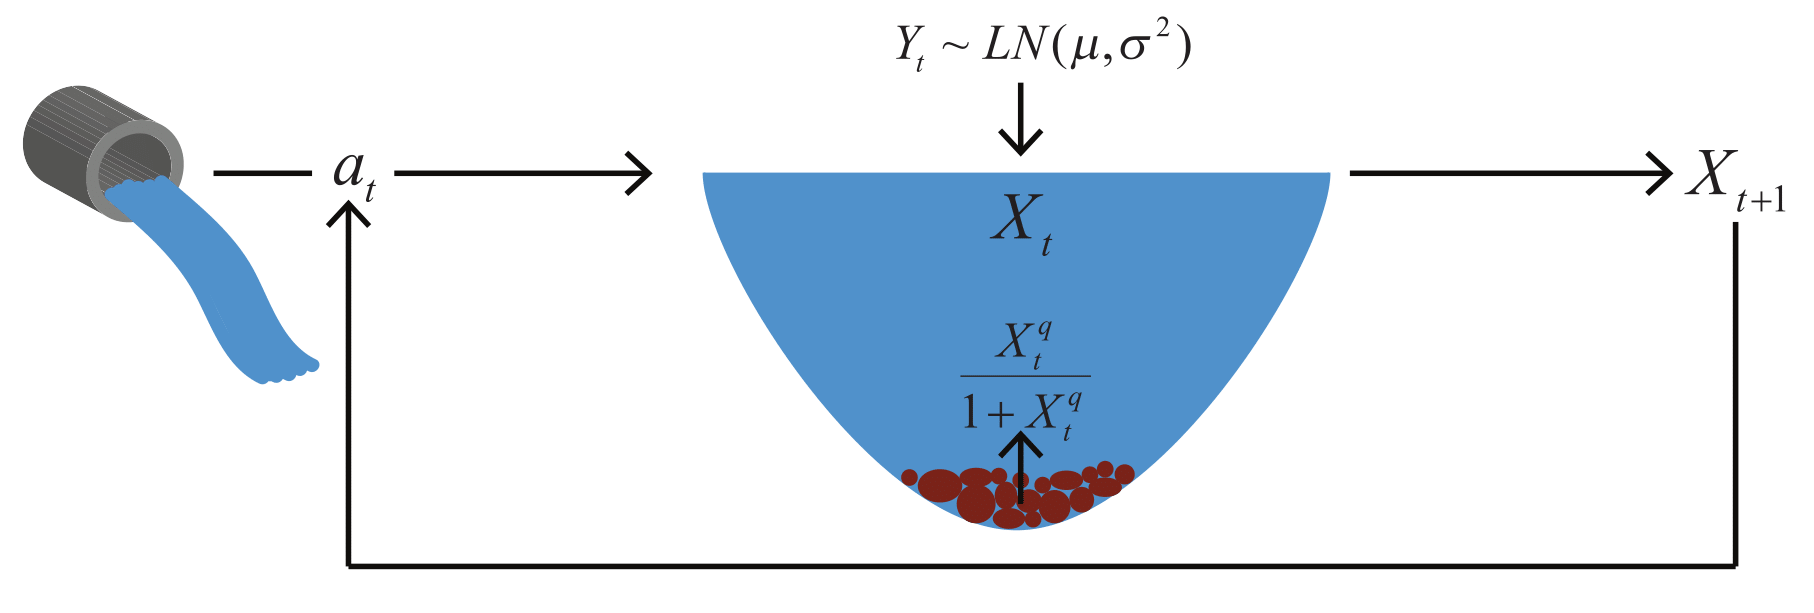

In [1]:
# Python implementation of a single-objective version of the lake problem
# using Direct Policy Search, optimized by NSGA-II

# Lake parameters
# b    : proportion of phosphorous lost from the lake each year;
# q    : steepness of the sigmoid curve, large values give a steeper slope;

# Parameters related to utiltiy
# delta : discount rate, set at 0.98
# alpha : utility from pollution, set at 0.4
# beta : loss in utility from high lake P concentration

# Lake state variabiles
# X : phosphorous concentration in the lake at a given time step;
# initially set to 0

# Stochasticity is introduced by natural variability around anthropogenic pollution flow,
# which is generated form a log-normal distribution for N = 100 ensemble members

# T : the time horizon for planning (100 years in this example)

# Decision variable
# vars : vector of length 3n describing the policy parameters
# n is the number of RBFs, each with a weight, center and radius
# format of vars is [c1, b1, w1, c2, b2, w2, ..., cn, bn, wn]
# all variables must be between 0 and 1, and all weights must sum to 1
# The weights determined by Borg aren't constrained to sum to 1,
# but are normalized to do so in the model simulation
# The actual decision, the amount of pollution emitted by the town, is Y,
# a function of vars and the current state of the lake (X)

# Objective
# expected utility: U = (1/N) * sum_N sum_T (delta**t)*(alpha*Y - beta*X^2)

import numpy as np
from scipy.optimize import root
import scipy.stats as ss
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

def LakeModel_DPS(vars, seed=123, b=0.42, q=2.0, mean=0.03, std=np.sqrt(10**(-5)), \
  delta=0.98, X0=0):
  '''
  b = linear P removal rate
  q = sigmoid P recycling rate
  mean = real-space mean of log-normally distributed non-point source pollution
  std = real-space standard deviation of log-normally distributed non-point source pollution
  delta = discount parameter
  X0 = initial lake P concentration
  '''

  # Set log-space inflow distribution parameters
  log_std = np.sqrt(np.log(1+std**2/mean**2))
  log_mean = np.log(mean) - 0.5*(log_std**2)

  # Initialize arrays to store average daily P and performance of solution in each generated sample
  discounted_utility = np.zeros([N])
  X = np.zeros([T+1])

  # Randomly generate N ensemble members of T of natural P inflows
  Y = np.zeros([N,T])
  for i in range(N):
    np.random.seed(seed+i)
    Y[i,:] = np.exp(ss.norm.rvs(log_mean, log_std, T))

  # Determine centers, radii and weights of RBFs
  C = vars[0::3]
  R = vars[1::3]
  W = vars[2::3]
  newW = np.zeros(len(W))

  # Normalize weights to sum to 1
  total = sum(W)
  if total != 0.0:
    for j in range(len(W)):
      newW[j] = W[j]/total
  else: # all weights equal
    for j in range(len(W)):
      newW[j] = 1/n

  # Run lake model simulation
  for i in range(N):
    X[0] = X0
    a = np.zeros([T])
    #find policy-derived emission
    a[0] = RBFpolicy(X[0], C, R, newW)

    for t in range(T):
      X[t+1] = X[t]*(1-b) + (X[t]**q)/(1+(X[t]**q)) + a[t] + Y[i,t]
      discounted_utility[i] = discounted_utility[i] + (alpha*a[t]-beta*X[t]**2)*(delta**t)

      if t<(T-1):
        #find policy-derived emission
        a[t+1] = RBFpolicy(X[t+1], C, R, newW)

  # Calculate minimization objectives (defined in comments at beginning of file)
  obj = np.mean(-discounted_utility) #average utility, negate for minimization

  return obj

def RBFpolicy(x, C, R, W):
  # Determine pollution emission decision, a
  a = 0
  for j in range(len(C)):
    if R[j] != 0:
      a = a + W[j]*((np.absolute(x-C[j])/R[j])**3)

  a = min(0.1,max(a,0.01))

  return a

In [2]:
# Set the number of RBFs (n), decision variables, objectives and constraints
n = 2
nvars = 3*n
nobjs = 4

# bounds on [center, radius, weight]*n RBFs
bounds = [[-2, 2],[0, 2],[0, 1]]*(n)

# Set lake model parameters, number of years simulated, and number of samples generated
alpha = 0.4 # benefit per unit P emitted
beta = 0.08 # cost per square unit P in lake
T = 100 # number of years simulated
N = 100 # number of ensemble members

# optimization with DE
result = differential_evolution(LakeModel_DPS, bounds=bounds, seed=1, maxiter=10)

Plot the decision rule of this policy.

Text(0, 0.5, '$a_t$')

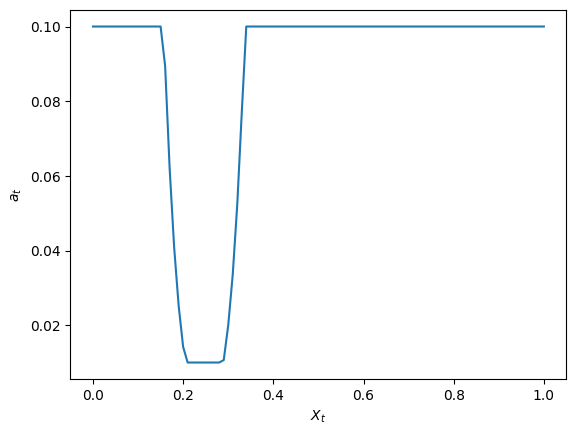

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(0,1.01,0.01)

def getDischarge(vars, x):
  a = np.zeros([len(x)])
  C = vars[0::3]
  R = vars[1::3]
  W = vars[2::3]
  newW = np.zeros(len(W))
  # Normalize weights to sum to 1
  total = sum(W)
  if total != 0.0:
    for j in range(len(W)):
      newW[j] = W[j]/total
  else: # all weights equal
    for j in range(len(W)):
      newW[j] = 1/n
  for i in range(len(x)):
    a[i] = RBFpolicy(x[i], C, R, W)
  return a

a = getDischarge(result.x, x)
ax.plot(x,a)
ax.set_xlabel(r"$X_t$")
ax.set_ylabel(r"$a_t$")

See how this decision rule affects the lake problem equilibria and safe operating space.

In [4]:
b = 0.42
q = 2
mean = 0.03
std = np.sqrt(10**(-5.0))
log_std = np.sqrt(np.log(1+std**2/mean**2))
log_mean = np.log(mean) - 0.5*(log_std**2)
log_99 = log_mean + log_std*ss.norm.ppf(0.99)
pct_99 = np.exp(log_99)

def equilibria(x, vars, include=None):
  if include == "human":
    a = getDischarge(vars, x)
    return (x[0]**q)/(1+x[0]**q) + a - b*x[0]
  elif include == "human+natural":
    a = getDischarge(vars, x)
    return (x[0]**q)/(1+x[0]**q) + a + mean - b*x[0]
  else:
    return (x[0]**q)/(1+x[0]**q) - b*x[0]

Text(0, 0.5, '$a_t$')

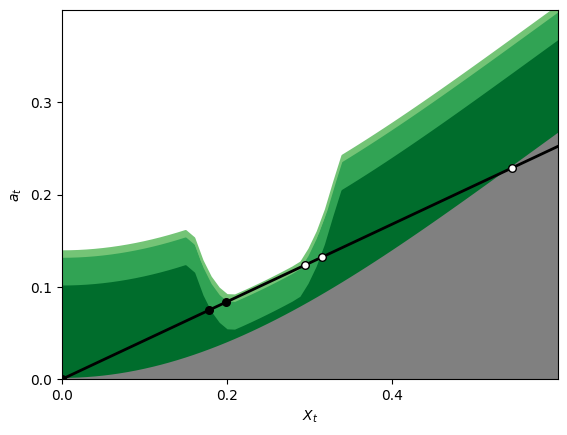

In [5]:
# get recycled P at different lake P levels
recycle = np.zeros(len(x))
for i in range(len(x)):
  recycle[i] = x[i]**q/(1+x[i]**q)

# plot equilibria under different policies
fig = plt.figure()
ax = fig.add_subplot(111)

# plot recycled P only
ax.plot(x, recycle, c='0.5', linewidth=2)
ax.fill_between(x, 0, recycle, facecolor='0.5')

# plot human inputs on top of recycled P
ax.plot(x, recycle + a, c="#006d2c", linewidth=2)
ax.fill_between(x, recycle, recycle + a, facecolor="#006d2c")

# plot mean natural inputs on top of human inputs + recycled P
ax.plot(x, recycle + a + mean, c="#31a354", linewidth=2)
ax.fill_between(x, recycle + a, recycle + a + mean, facecolor="#31a354")

# plot 99th-percentile natural inputs on top of mean natural flows + human inputs + recycled P
ax.plot(x, recycle + a + pct_99, c="#74c476", linewidth=2)
ax.fill_between(x, recycle + a + mean, recycle + a + pct_99, facecolor="#74c476")

# plot line for P sinks
ax.plot(x, b*x, c="k", linewidth=2)

# plot oligotrophic equilibria for 1) just recycle, 2) recycle + human, 3) recycle + human + natural mean
ax.scatter(0, 0, facecolor="k", edgecolor="k", s=30, zorder=3)
human_eq = root(equilibria, [0.2], args=(result.x, "human"))
ax.scatter(human_eq.x, b*human_eq.x, facecolor="k", edgecolor="k", s=30, zorder=3)
human_nat_eq = root(equilibria, [0.2], args=(result.x, "human+natural"))
ax.scatter(human_nat_eq.x, b*human_nat_eq.x, facecolor="k", edgecolor="k", s=30, zorder=3)

# find tipping point on 1) just recycle, 2) recycle + human, 3) recycle + human + natural mean
recycle_eq = root(equilibria, 0.5, args=(recycle))
ax.scatter(recycle_eq.x, b*recycle_eq.x, facecolor="w", edgecolor="k", s=30, zorder=3)
human_eq = root(equilibria, [0.4], args=(result.x, "human"))
ax.scatter(human_eq.x, b*human_eq.x, facecolor="w", edgecolor="k", s=30, zorder=3)
human_nat_eq = root(equilibria, [0.4], args=(result.x, "human+natural"))
ax.scatter(human_nat_eq.x, b*human_nat_eq.x, facecolor="w", edgecolor="k", s=30, zorder=3)

# zoom in on safe operating space
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.4)
ax.set_xticks(np.arange(0,0.6,0.2))
ax.set_yticks(np.arange(0,0.4,0.1))

# labels
ax.set_xlabel(r"$X_t$")
ax.set_ylabel(r"$a_t$")

Plot time series of decisions made by optimal policy.

In [6]:
def LakeModel_Sim(vars, seed=123, b=0.42, q=2.0, mean=0.03, std=np.sqrt(10**(-5)), \
  delta=0.98, X0=0):
  '''
  b = linear P removal rate
  q = sigmoid P recycling rate
  mean = real-space mean of log-normally distributed non-point source pollution
  std = real-space standard deviation of log-normally distributed non-point source pollution
  delta = discount parameter
  X0 = initial lake P concentration
  '''

  # Set log-space inflow distribution parameters
  log_std = np.sqrt(np.log(1+std**2/mean**2))
  log_mean = np.log(mean) - 0.5*(log_std**2)

  # Initialize arrays to store average daily P and performance of solution in each generated sample
  discounted_benefit = np.zeros([N])
  yrs_Pcrit_met = np.zeros([N])
  X = np.zeros([N,T+1])
  a = np.zeros([N,T])

  # Randomly generate N ensemble members of T years of natural P inflows
  Y = np.zeros([N,T])
  for i in range(N):
    np.random.seed(seed+i)
    Y[i,:] = np.exp(ss.norm.rvs(log_mean, log_std, T))

  # Determine centers, radii and weights of RBFs
  C = vars[0::3]
  R = vars[1::3]
  W = vars[2::3]
  newW = np.zeros(len(W))

  # Normalize weights to sum to 1
  total = sum(W)
  if total != 0.0:
    for j in range(len(W)):
      newW[j] = W[j]/total
  else: # all weights equal
    for j in range(len(W)):
      newW[j] = 1/n

  # Run lake model simulation
  for i in range(N):
    X[i,0] = X0
    #find policy-derived emission
    a[i,0] = RBFpolicy(X[i,0], C, R, newW)

    for t in range(T):
      X[i,t+1] = X[i,t]*(1-b) + (X[i,t]**q)/(1+(X[i,t]**q)) + a[i,t] + Y[i,t]
      discounted_benefit[i] = discounted_benefit[i] + alpha*a[i,t]*delta**t

      if t<(T-1):
        #find policy-derived emission
        a[i,t+1] = RBFpolicy(X[i,t+1], C, R, newW)

  return X, a

X, a = LakeModel_Sim(result.x)

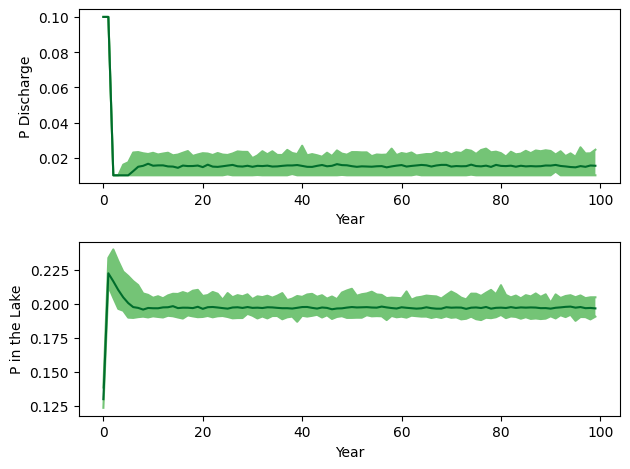

In [10]:
fig, ax = plt.subplots(2,1)

variable = [a,X[:,1::]]

for i in range(2):
  ax[i].plot(range(T), np.min(variable[i],0), color="#74c476") # minimum at each time step
  ax[i].plot(range(T), np.max(variable[i],0), color="#74c476") # maximum at each time step
  ax[i].fill_between(range(T), np.min(variable[i],0), np.max(variable[i],0), facecolor="#74c476")
  ax[i].plot(range(T), np.median(variable[i],0), color="#006d2c") # median at each time step
  ax[i].set_xlabel("Year")
  if i == 0:
    ax[i].set_ylabel("P Discharge")
  else:
    ax[i].set_ylabel("P in the Lake")

fig.tight_layout()